# Introducción a Sentiment Analysis

Bibliografía: 

* [Sentiment Symposium Tutorial](http://sentiment.christopherpotts.net/)
* Notebooks del [curso cs224u](https://web.stanford.edu/class/cs224u/) de Stanford: [Stanford Sentiment Treebank](https://nbviewer.jupyter.org/github/cgpotts/cs224u/blob/master/sst_01_overview.ipynb), [Feature Representations](https://nbviewer.jupyter.org/github/cgpotts/cs224u/blob/master/sst_02_hand_built_features.ipynb), [Models](https://nbviewer.jupyter.org/github/cgpotts/cs224u/blob/master/sst_03_neural_networks.ipynb)

"Análisis de sentimientos" (*sentiment analysis* en inglés) es la tarea que involucra identificar y estudiar, entre otras cosas, emociones, sentimientos, actitudes y opiniones que aparecen en el lenguaje. 

FALTA:
* Aplicaciones
* Estudios cognitivos y lingüísticos sobre la forma de expresar sentimientos

## Preparando el texto

En general, todas las tareas de NLP pueden variar mucho su performance según cómo sea preprocesado el texto. En este caso no nos vamos a hacer problema por esto y suponemos que la tarea de tokenización ya fue resulta en una forma en que fue tomado en cuenta que el problema a encarar es el análisis de sentimientos. ¿Qué significa esto? Supongamos el siguiente *tweet*:
```
@SentimentSymp:  can't wait for the Nov 9 #Sentiment talks! 
YAAAAAAY!!! >:-D http://sentimentsymposium.com/.
```
Esto puede tener varias formas de dividir en tokens, y más aún teniendo en cuenta que algunas palabras denotan emociones. Por ejemplo, `YAAAAAAY!!!`, `YAAAY!!!`, `YAAAY!` o `yaay!` podrían corresponder al mismo token y mantener el mismo sentido. De esta manera, se evitan problemas de esparcicidad en la codificación de las palabras. 

En lo que sigue vamos a utilizar el [*Large Movie Review Dataset v1.0* dataset](https://ai.stanford.edu/~amaas/data/sentiment/) que contiene *reviews* de películas y su correspondiente clasificación en "positiva" o "negativa". Además, utilizaremos la librería [NLTK](https://www.nltk.org/api/nltk.tokenize.html) para realizar la tokenización.

In [1]:
import nltk
from nltk.tokenize import TweetTokenizer

t = """@SentimentSymp:  can't wait for the Nov 9 #Sentiment talks! 
YAAAAAAY!!! >:-D http://sentimentsymposium.com/."""

tokenizer = TweetTokenizer()
t_tokenized = tokenizer.tokenize(t)
print(t_tokenized)

['@SentimentSymp', ':', "can't", 'wait', 'for', 'the', 'Nov', '9', '#Sentiment', 'talks', '!', 'YAAAAAAY', '!', '!', '!', '>:-D', 'http://sentimentsymposium.com/', '.']


Además de la tokenización existen varios procesos que aportan información y mejoran la performance de los modelos de análisis de sentimientos. Por ejemplo, ciertos tipos de *stemming* ayudan a reducir la dimensión del vocabulario y por lo tanto, suele aumentar el rendimiento significativamente para datasets con pocas muestras. Sin embargo a veces esto puede ser contraproducente. Por otro lado, también suelen existir datasets que contienen *Part-Of-Speech (POS) Tagging*, lo que significa que cada token viene acompañado de información semántica, sintáctica o inclusive con información sobre el sentimiento de la palabra. Por el momento no se implentará ninguna de estas técnicas más que la tokenización con conocimiento de sentimientos (descrita más arriba).

In [2]:
# Obtenemos el corpus

import os
import nltk
from nltk.tokenize import TweetTokenizer

POS_ROOT_PATH = '../../Utils/Datasets/aclImdb/train/pos'
NEG_ROOT_PATH = '../../Utils/Datasets/aclImdb/train/neg'
pos_filenames = os.listdir(POS_ROOT_PATH)[:3]
neg_filenames = os.listdir(NEG_ROOT_PATH)[:3]
tokenizer = TweetTokenizer()
corpus = []
for filename in pos_filenames:
    with open(os.path.join(POS_ROOT_PATH,filename), 'r') as f:
        corpus.append(tokenizer.tokenize(f.read()))
for filename in neg_filenames:
    with open(os.path.join(NEG_ROOT_PATH,filename), 'r') as f:
        corpus.append(tokenizer.tokenize(f.read()))

print('Number of documents in corpus: {}'.format(len(corpus)))
print('Number of total tokens in corpus: {}'.format(sum([len(doc) for doc in corpus])))

Number of documents in corpus: 6
Number of total tokens in corpus: 1640


Vocabulary size: 690


Text(0, 0.5, 'frequencies')

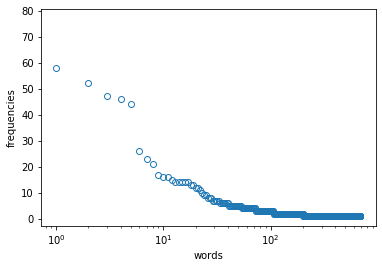

In [3]:
# Definimos el vocabulario para el corpus

import itertools
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def get_vocab_from_corpus(corpus):
    vocab = {token: 0 for token in list(set(itertools.chain.from_iterable(corpus)))}
    for token in itertools.chain.from_iterable(corpus):
        vocab[token] += 1
    return vocab
    
vocab = get_vocab_from_corpus(corpus)
print('Vocabulary size: {}'.format(len(vocab)))
plt.semilogx(np.arange(len(vocab)), sorted(vocab.values(),reverse=True), marker='o', fillstyle='none', linestyle='none')
plt.xlabel('words')
plt.ylabel('frequencies')

En base a esto definimos un vocabulario de xxxxx palabras que va a contener a los tokens más frecuentes, y el resto serán considerados como `<UNK>` (desconocidos) y serán ignorados, tanto para el entrenamiento como para la evaluación.

In [12]:
def get_dataset_and_vocab(root, vocab_list):
    tk_to_idx = {tk: idx for idx, tk in enumerate(vocab_list)}
    idx_to_tk = {idx: tk for idx, tk in enumerate(vocab_list)}
    POS_ROOT_PATH = os.path.join(root,'pos')
    NEG_ROOT_PATH = os.path.join(root,'neg')
    pos_filenames = os.listdir(POS_ROOT_PATH)[:3]
    neg_filenames = os.listdir(NEG_ROOT_PATH)[:3]
    data_len = len(pos_filenames) + len(neg_filenames)
    tokenizer = TweetTokenizer()
    data = [] # Neg sample: ([1,4,5,...], 0), Pos sample: ([1,4,5,...], 1)
    for filename in pos_filenames:
        with open(os.path.join(POS_ROOT_PATH,filename), 'r') as f:
            data.append((['<START>'] + tokenizer.tokenize(f.read()) + ['<END>'],1))
    for filename in neg_filenames:
        with open(os.path.join(NEG_ROOT_PATH,filename), 'r') as f:
            data.append((['<START>'] + tokenizer.tokenize(f.read()) + ['<END>'],0))
    data_idx = [([tk_to_idx.get(tk,-1) for tk in data[i][0]],data[i][1]) for i in range(data_len)]
    return data_idx, idx_to_tk

ROOT_PATH = '../../Utils/Datasets/aclImdb/train/'
vocab_list = sorted(list(vocab.keys()) + ['<START>', '<END>'])
data, idx_to_tk = get_dataset_and_vocab(ROOT_PATH, vocab_list)
print([idx_to_tk.get(idx,'<UNK>') for idx in data[0][0]])

['<START>', 'Exquisite', 'comedy', 'starring', 'Marian', 'Davies', '(', 'with', 'the', 'affable', 'William', 'Haines', ')', '.', 'Young', 'Peggy', 'arrives', 'in', 'Hollywood', 'seeking', 'stardom', '.', 'Cameo', 'performances', 'showcase', '"', 'all', 'the', 'stars', 'in', "MGM's", 'heaven', '"', 'in', 'the', 'famous', 'commissary', 'scene', ',', 'plus', 'lots', 'of', 'vintage', 'film', 'making', 'detail', 'for', 'the', 'scholar', '.', 'Pic', 'also', 'captures', 'for', 'posterity', 'Davies', "'", 'famous', ',', 'wickedly', 'sarcastic', 'impersonations', 'of', 'the', 'top', 'stars', 'of', 'the', 'day', '(', 'her', 'Swanson', 'is', '<UNK>', 'beaut', '!', ')', '.', '<', 'br', '/', '>', '<', 'br', '/', '>', '"', 'Peggy', ',', '"', 'even', 'catches', 'herself', 'as', 'she', 'encounters', 'the', 'famous', 'star', 'Marian', 'Davies', 'at', 'tennis', ',', 'turns', 'up', 'her', 'nose', 'and', 'comments', ',', '"', 'Ohh', ',', 'I', "don't", 'like', 'her', '!', '"', '<', 'br', '/', '>', '<', 'br

A continuación se verán algunos modelos de clasificación para implementar el analizador de sentimientos. En todos los casos se considerará que las únicas clases posibles son "Poistivo" y "Negativo", y se utilizará el dataset definido anteriormente.

## Clasificación con Naive Bayes

El método de Naive Bayes es un ejemplo de modelos generativos que se utilizan para clasificar texto. 

EXPLICAR QUÉ ES BAG OF WORDS

## Clasificación con Bag-Of-Words lineal

A continuación se implementará un modelo neuronal que consiste en una capa que convierte a la entrada en un elemento del espacio semántico (un *word embedding*), y una capa de salida que realiza la clasificación binaria (regresión logística).

## Clasificación con RNN